In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL','NFLX']
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

for i in tickers:
    try:
        test_data = pdr.get_data_yahoo(i, start = dt.datetime(1990,1,1), end = dt.date.today())
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
    except:
        no_data.append(i)

#Creating Return column
all_data['return'] = all_data.groupby('symbol')['Close'].pct_change() 

In [3]:
all_data['SMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']

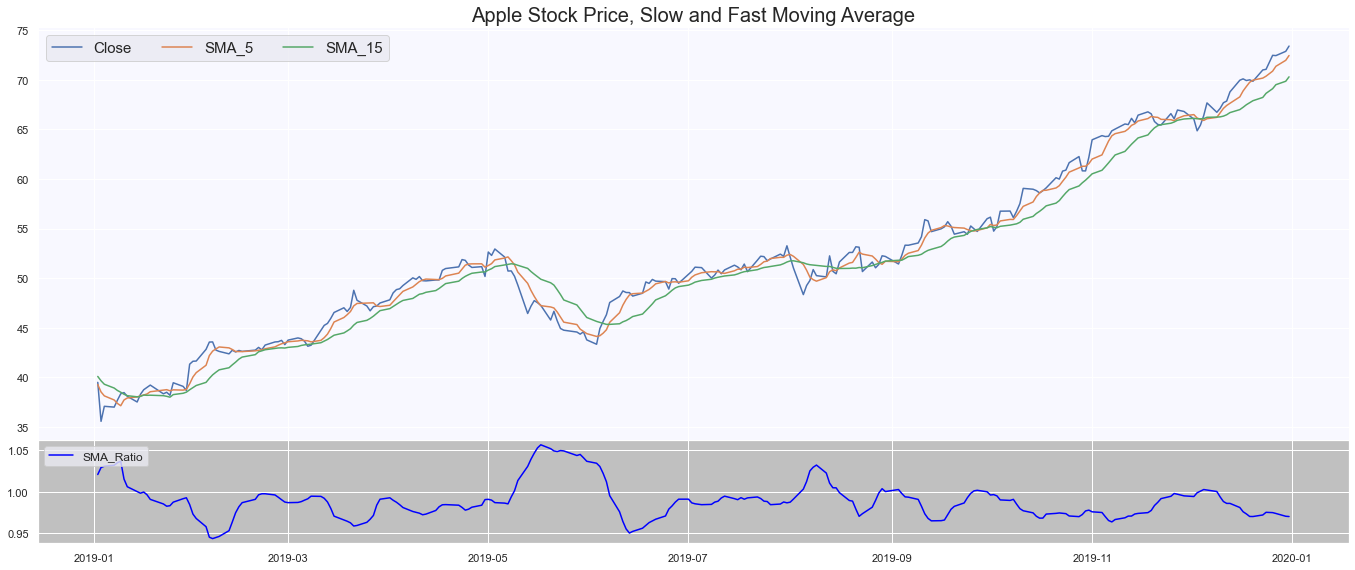

In [4]:
#Plotting
start = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
end = dt.datetime.strptime('2019-12-31', '%Y-%m-%d')
sns.set()

fig = plt.figure(facecolor = 'white', figsize = (20,10))

ax0 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
ax0.plot(all_data[all_data.symbol=='AAPL'].loc[start:end,['Close','SMA_5','SMA_15']])
ax0.set_facecolor('ghostwhite')
ax0.legend(['Close','SMA_5','SMA_15'],ncol=3, loc = 'upper left', fontsize = 15)
plt.title("Apple Stock Price, Slow and Fast Moving Average", fontsize = 20)

ax1 = plt.subplot2grid((6,4), (5,0), rowspan=1, colspan=4, sharex = ax0)
ax1.plot(all_data[all_data.symbol=='AAPL'].loc[start:end,['SMA_ratio']], color = 'blue')
ax1.legend(['SMA_Ratio'],ncol=3, loc = 'upper left', fontsize = 12)
ax1.set_facecolor('silver')
plt.subplots_adjust(left=.09, bottom=.09, right=1, top=.95, wspace=.20, hspace=0)
plt.show()

In [5]:
all_data['SMA5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_Volume_Ratio'] = all_data['SMA5_Volume']/all_data['SMA15_Volume']

In [6]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [9]:
all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                     np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                     abs(all_data['prev_close'] - all_data['Low'])))
for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)

all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

In [10]:
all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                           np.where((all_data['High'] > all_data['prev_high']) & 
         (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                  all_data['High'] - all_data['prev_high'], 
                                                                  0),np.nan)

all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                           np.where((all_data['prev_low'] > all_data['Low']) & 
         (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_5'] = Wilder(ADX_data['+DM'], 5)
    all_data.loc[all_data.symbol==i,'-DM_5'] = Wilder(ADX_data['-DM'], 5)
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)

all_data['+DI_5'] = (all_data['+DM_5']/all_data['ATR_5'])*100
all_data['-DI_5'] = (all_data['-DM_5']/all_data['ATR_5'])*100
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100

all_data['DX_5'] = (np.round(abs(all_data['+DI_5'] - all_data['-DI_5'])/(all_data['+DI_5'] + all_data['-DI_5']) * 100))

all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_5'] = Wilder(ADX_data['DX_5'], 5)
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

In [11]:
all_data['Lowest_5D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 5).min())
all_data['High_5D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 5).max())
all_data['Lowest_15D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 15).min())
all_data['High_15D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 15).max())

all_data['Stochastic_5'] = ((all_data['Close'] - all_data['Lowest_5D'])/(all_data['High_5D'] - all_data['Lowest_5D']))*100
all_data['Stochastic_15'] = ((all_data['Close'] - all_data['Lowest_15D'])/(all_data['High_15D'] - all_data['Lowest_15D']))*100

all_data['Stochastic_%D_5'] = all_data['Stochastic_5'].rolling(window = 5).mean()
all_data['Stochastic_%D_15'] = all_data['Stochastic_5'].rolling(window = 15).mean()

all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_5']/all_data['Stochastic_%D_15']

In [12]:
all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
all_data['Up'] = all_data['Diff']
all_data.loc[(all_data['Up']<0), 'Up'] = 0

all_data['Down'] = all_data['Diff']
all_data.loc[(all_data['Down']>0), 'Down'] = 0 
all_data['Down'] = abs(all_data['Down'])

all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

In [13]:
all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

In [14]:
all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

In [15]:
all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15))